In [1]:
import tensorflow as tf
import os
import numpy as np

In [2]:
train_val_files = np.array([os.path.join("./mnist_train/", i, j) for i in os.listdir("./mnist_train/") for j in os.listdir(os.path.join("./mnist_train/", i))])

In [3]:
len(train_val_files)

60000

In [4]:
print(train_val_files[:3])

['./mnist_train/4/mnist_train_43608.png'
 './mnist_train/4/mnist_train_39324.png'
 './mnist_train/4/mnist_train_50389.png']


In [5]:
train_val_labels = np.array([i.split("/")[2] for i in train_val_files]).astype(np.int32)

In [7]:
len(train_val_labels)

60000

In [8]:
# 训练集和验证集的划分
from sklearn.model_selection import train_test_split

train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels, test_size=0.2, random_state=1234)

In [9]:
print(train_files[:3])
print(train_files.shape)

['./mnist_train/3/mnist_train_37167.png'
 './mnist_train/4/mnist_train_4346.png'
 './mnist_train/6/mnist_train_46003.png']
(48000,)


In [10]:
print(train_labels[:3])
print(train_labels.shape)

[3 4 6]
(48000,)


In [11]:
train_file_label = np.column_stack((train_files, train_labels))

In [12]:
val_file_label = np.column_stack((val_files, val_labels))

In [13]:
print(train_file_label.shape)
print(train_file_label[:3])

(48000, 2)
[['./mnist_train/3/mnist_train_37167.png' '3']
 ['./mnist_train/4/mnist_train_4346.png' '4']
 ['./mnist_train/6/mnist_train_46003.png' '6']]


In [14]:
print(val_file_label.shape)
print(val_file_label[:3])

(12000, 2)
[['./mnist_train/7/mnist_train_59646.png' '7']
 ['./mnist_train/9/mnist_train_27780.png' '9']
 ['./mnist_train/7/mnist_train_53253.png' '7']]


In [15]:
np.savetxt("./train.csv", train_file_label, delimiter=",", fmt="%s")

In [16]:
np.savetxt("./val.csv", val_file_label, delimiter=",", fmt="%s")

In [44]:
test_files = np.array([os.path.join("./mnist_test/", i, j) for i in os.listdir("./mnist_test/") for j in os.listdir(os.path.join("./mnist_test/", i))])
print(test_files.shape)
print(test_files[:3])

(10000,)
['./mnist_test/4/mnist_test_9871.png' './mnist_test/4/mnist_test_6715.png'
 './mnist_test/4/mnist_test_3410.png']


In [45]:
test_labels = np.array([i.split("/")[2] for i in test_files])
print(test_labels.shape)
print(test_labels[:3])

(10000,)
['4' '4' '4']


In [46]:
test_file_label = np.column_stack((test_files, test_labels))
print(test_file_label.shape)
print(test_file_label[:3])

(10000, 2)
[['./mnist_test/4/mnist_test_9871.png' '4']
 ['./mnist_test/4/mnist_test_6715.png' '4']
 ['./mnist_test/4/mnist_test_3410.png' '4']]


In [47]:
np.savetxt("test.csv", test_file_label, delimiter=",", fmt="%s")

In [17]:
# 构建训练集的dataset
train_names = ["./train.csv"]
record_defaults = [tf.string, tf.int32]
train_ds = tf.data.experimental.CsvDataset(train_names, record_defaults)

In [18]:
train_ds.output_types

(tf.string, tf.int32)

In [19]:
train_ds.output_shapes

(TensorShape([]), TensorShape([]))

b'./mnist_train/4/mnist_train_43608.png'
4
Tensor("DecodePng_1:0", shape=(?, ?, ?), dtype=uint8)


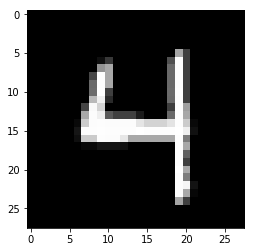

In [8]:
# 检查数据集对不对
# iterator = train_ds.make_one_shot_iterator()
# next_element = iterator.get_next()
# import matplotlib.pyplot as plt

# with tf.Session() as sess:
#     for i in range(1):
#         img, label = sess.run(next_element)
#         print(img)
#         print(label)
#         im_string = tf.read_file(img)
#         im = tf.image.decode_png(im_string)
#         print(im)
#         img = sess.run(im)
#         img = img.squeeze()
#         plt.imshow(img, cmap="gray")
#         plt.show()

In [20]:
# 构建验证集的dataset
val_names = ["./val.csv"]
record_defaults = [tf.string, tf.int32]
val_ds = tf.data.experimental.CsvDataset(val_names, record_defaults)

In [21]:
# 构建测试集的dataset
test_names = ["./test.csv"]
record_defaults = [tf.string, tf.int32]
test_ds = tf.data.experimental.CsvDataset(test_names, record_defaults)

In [22]:
print(test_ds.output_types)
print(test_ds.output_shapes)

(tf.string, tf.int32)
(TensorShape([]), TensorShape([]))


b'./mnist_test/4/mnist_test_9871.png'
4


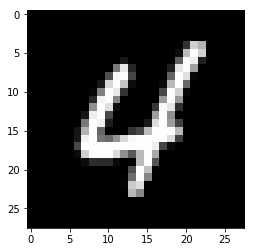

In [13]:
# 测试集dataset的对错
# iterator = test_ds.make_one_shot_iterator()
# next_element = iterator.get_next()

# with tf.Session() as sess:
#     for i in range(1):
#         im, lab = sess.run(next_element)
#         print(im)
#         print(lab)
#         im_string = tf.read_file(im)
#         img = tf.image.decode_png(im_string)
#         img = tf.cast(img, tf.float32)
#         img = tf.squeeze(img)
#         img = sess.run(img)
#         plt.imshow(img, cmap="gray")
#         plt.show()

In [23]:
# dataset转换函数
def _parse_image(filename, label):
    """dataset转换函数"""
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_png(image_string)
    image_reshape = tf.reshape(image_decoded, [28, 28, 1])
    image_converted = tf.cast(image_reshape, tf.float32)
    image_scaled = tf.divide(image_converted, 255.)
    return image_scaled, label

In [24]:
# 训练集dataset和测试集dataset转换
import multiprocessing as mt

train_ds = train_ds.map(_parse_image, num_parallel_calls=mt.cpu_count())
val_ds = val_ds.map(_parse_image, num_parallel_calls=mt.cpu_count())
test_ds = test_ds.map(_parse_image, num_parallel_calls=mt.cpu_count())

In [25]:
print(train_ds.output_shapes)
print(train_ds.output_types)

(TensorShape([Dimension(28), Dimension(28), Dimension(1)]), TensorShape([]))
(tf.float32, tf.int32)


In [26]:
train_ds = train_ds.shuffle(48000).batch(100)
val_ds = val_ds.shuffle(12000).batch(100)

In [27]:
print(train_ds.output_types)
print(train_ds.output_shapes)

(tf.float32, tf.int32)
(TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]), TensorShape([Dimension(None)]))


In [28]:
# 创建可馈送迭代器句柄
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle, train_ds.output_types, train_ds.output_shapes)
data_x, data_y = iterator.get_next()

In [29]:
# 为训练集和验证集创建可重新初始化迭代器，为测试集创建one-shot迭代器
train_val_iterator = tf.data.Iterator.from_structure(train_ds.output_types, train_ds.output_shapes)
train_iterator = train_val_iterator.make_initializer(train_ds)
val_iterator = train_val_iterator.make_initializer(val_ds)
test_iterator = test_ds.make_one_shot_iterator()

In [ ]:
# 创建LeNet-5模型
class MyModel:
    def __init__(self, data_x, data_y):
        self.n_classes = 10
    
    def _create_architecture(self, x, y):
    
    def _create_model(self, x):